# Exercise 3

For this exercise, it is proposed that we develop a program that can detect two different augmented reality markers in an scene and draws a rectangle of different colors around each one.

We start by importing some libraries and the images we will be using.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

scene = cv2.imread("images/full.png")
scene_gray = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
marker1 = cv2.imread("images/marker1.png", cv2.IMREAD_GRAYSCALE)
marker2 = cv2.imread("images/marker2.png", cv2.IMREAD_GRAYSCALE)

def display_image(img, title=""):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Then, we start by defining the corners in the template images of the markers, so that we can later match them with the detected corners in the scene.

In [2]:
marker1_corners = [
    (0, 0),
    (marker1.shape[1], 0),
    (marker1.shape[1], marker1.shape[0]),
    (0, marker1.shape[0]),
]

marker2_corners = [
    (0, 0),
    (marker2.shape[1], 0),
    (marker2.shape[1], marker2.shape[0]),
    (0, marker2.shape[0]),
]

Now, we need to get the corners of the markers in the scene. This step was having terrible results with automatic corner detection algorithms, so here we will be performing it manually, selecting each corner in the picture, and pressing 'q' when we are finished.

In [3]:
i = 0

def mouse_callback(event, x, y, flags, param):
    global i

    if i >= 8:
        return

    if event == cv2.EVENT_LBUTTONDOWN:
        if i < 4:
            pts1[i] = [x, y]
            cv2.circle(scene_copy, (x, y), 5, (0, 255, 0), -1)
        else:
            pts2[i - 4] = [x, y]
            cv2.rectangle(scene_copy, (x - 5, y - 5), (x + 5, y + 5), (0, 0, 255), -1)
        i += 1
        cv2.imshow("image", scene_copy)


pts1 = np.zeros((4, 2), dtype=np.float32)
pts2 = np.zeros((4, 2), dtype=np.float32)
scene_copy = scene.copy()

print("Select the 4 corners of each marker and press 'q' to continue")

cv2.imshow("image", scene_copy)
cv2.setMouseCallback("image", mouse_callback)

# Wait for 'q' to quit all windows
KEY = -1
while KEY != ord("q") and i < 8:
    KEY = cv2.waitKey(0)

cv2.destroyAllWindows()


Select the 4 corners of each marker and press 'q' to continue


We can now calculate the transformation between the template markers and the scene markers.

In [5]:
H1, _ = cv2.findHomography(np.float32(marker1_corners), pts1, cv2.RANSAC, 5.0)
H2, _ = cv2.findHomography(np.float32(marker2_corners), pts2, cv2.RANSAC, 5.0)

print("Homography Matrix 1:\n", H1)
print("Homography Matrix 2:\n", H2)

Homography Matrix 1:
 [[ 3.73210594e-01 -2.97116845e-02  3.14000000e+02]
 [-2.15181354e-02  1.72087627e-01  1.37000000e+02]
 [ 1.08230219e-04 -2.01751648e-04  1.00000000e+00]]
Homography Matrix 2:
 [[ 3.27465025e-01 -5.50693512e-02  4.80000000e+01]
 [-2.86451773e-02  1.39436518e-01  8.10000000e+01]
 [-2.31164320e-05 -3.57812528e-04  1.00000000e+00]]


Now, we can use the homographies to draw the markers on the same plane as they appear in the scene, using `warpPerspective()`

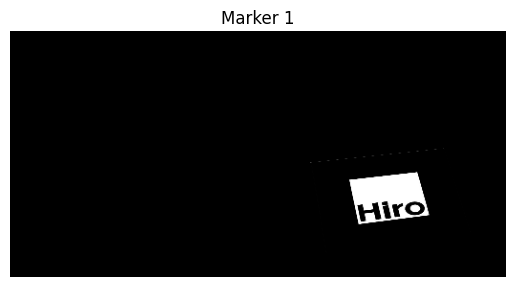

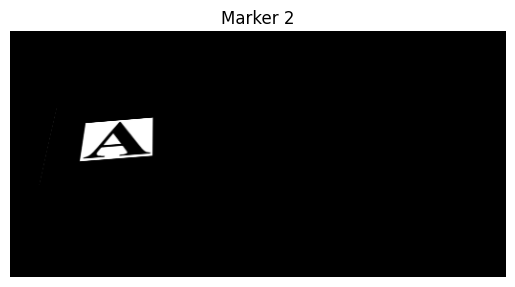

In [7]:
marker_frontal1 = cv2.warpPerspective(
    marker1,
    H1,
    (scene.shape[1], scene.shape[0]),
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0,
)

marker_frontal2 = cv2.warpPerspective(
    marker2,
    H2,
    (scene.shape[1], scene.shape[0]),
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0,
)

display_image(marker_frontal1, "Marker 1")
display_image(marker_frontal2, "Marker 2")


We can threshold the result to ensure more precise results on later steps

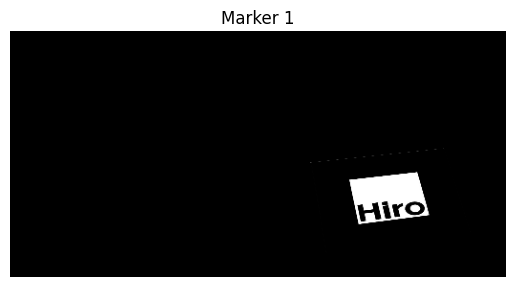

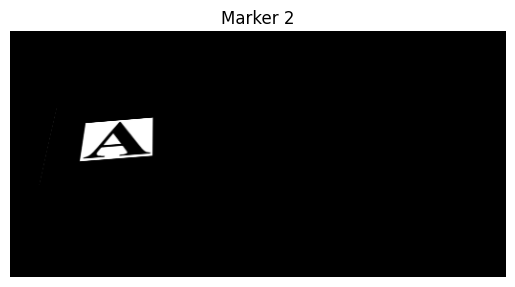

In [12]:
_, thresh1 = cv2.threshold(marker_frontal1, 127, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(marker_frontal2, 127, 255, cv2.THRESH_BINARY)
display_image(marker_frontal1, "Marker 1")
display_image(marker_frontal2, "Marker 2")

Next, we crop the images so that the templates that we will be using  for template matching only contain the markers.

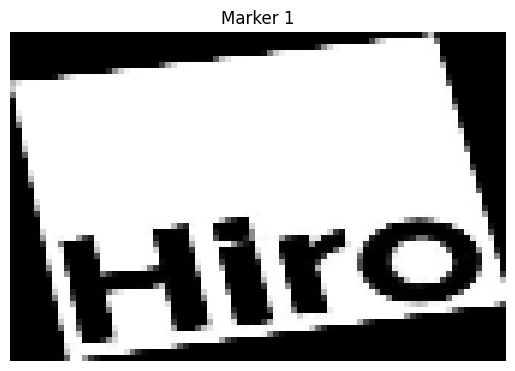

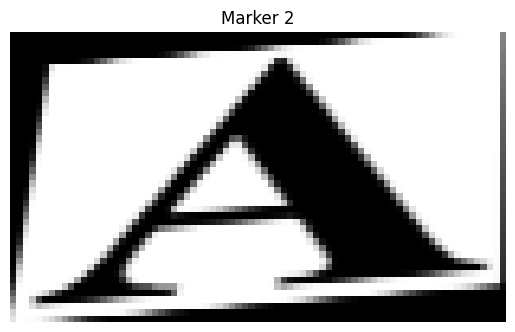

In [10]:
# Crop markers
coords1 = cv2.findNonZero(thresh1)
x1, y1, w1, h1 = cv2.boundingRect(coords1)
cropped_marker1 = marker_frontal1[y1 : y1 + h1, x1 : x1 + w1]

coords2 = cv2.findNonZero(thresh2)
x2, y2, w2, h2 = cv2.boundingRect(coords2)
cropped_marker2 = marker_frontal2[y2 : y2 + h2, x2 : x2 + w2]

display_image(cropped_marker1, "Marker 1")
display_image(cropped_marker2, "Marker 2")

Finally, we need to match the templates with the scene, using `matchTemplate()` and draw the corresponding rectangles. Note that we try plenty of possible scales so that the image we are matching and the marker in the scene are of the same size.

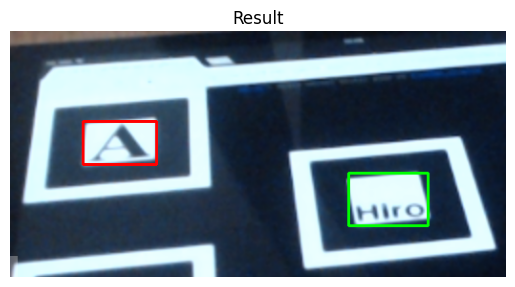

In [11]:
scales = [0.5, 0.75, 1.0, 1.25, 1.5]

best_scale = 1.0
best_match_val1 = -1
best_match_val2 = -1
best_top_left1 = None
best_top_left2 = None

for scale in scales:
    scaled_scene = cv2.resize(scene_gray, None, fx=scale, fy=scale)

    res1 = cv2.matchTemplate(scaled_scene, cropped_marker1, cv2.TM_CCOEFF_NORMED)
    res2 = cv2.matchTemplate(scaled_scene, cropped_marker2, cv2.TM_CCOEFF_NORMED)

    min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(res1)
    min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(res2)

    if max_val1 > best_match_val1:
        best_match_val1 = max_val1
        best_top_left1 = max_loc1
        best_scale = scale

    if max_val2 > best_match_val2:
        best_match_val2 = max_val2
        best_top_left2 = max_loc2

best_top_left1 = (
    int(best_top_left1[0] / best_scale),
    int(best_top_left1[1] / best_scale),
)
bottom_right1 = (best_top_left1[0] + w1, best_top_left1[1] + h1)
cv2.rectangle(scene, best_top_left1, bottom_right1, (0, 255, 0), 2)

best_top_left2 = (
    int(best_top_left2[0] / best_scale),
    int(best_top_left2[1] / best_scale),
)
bottom_right2 = (best_top_left2[0] + w2, best_top_left2[1] + h2)
cv2.rectangle(scene, best_top_left2, bottom_right2, (0, 0, 255), 2)

display_image(scene, "Result")